# Sentiment Analysis on Amazon Product Reviews of Uplocked Mobile Phones

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word Cloud](#part4)


---
<a id="part1"></a>
## Part 1. Data Exploration

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
# using crossvalidation for splitting data into training and test data
from sklearn import model_selection
from sklearn.model_selection import train_test_split 

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import nltk
# imports needed and set up logging
import gzip
import gensim 


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


### Load Data

In [13]:
# Load csv file
df = pd.read_csv('D:/SEMESTER 7/NLP/WEEK 11/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


### Data Exploration

In [14]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


### Data Visualization 

Text(0, 0.5, 'Count')

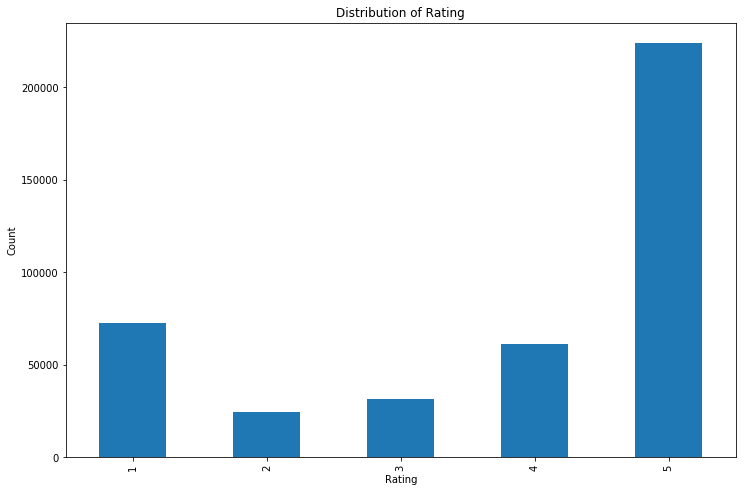

In [15]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

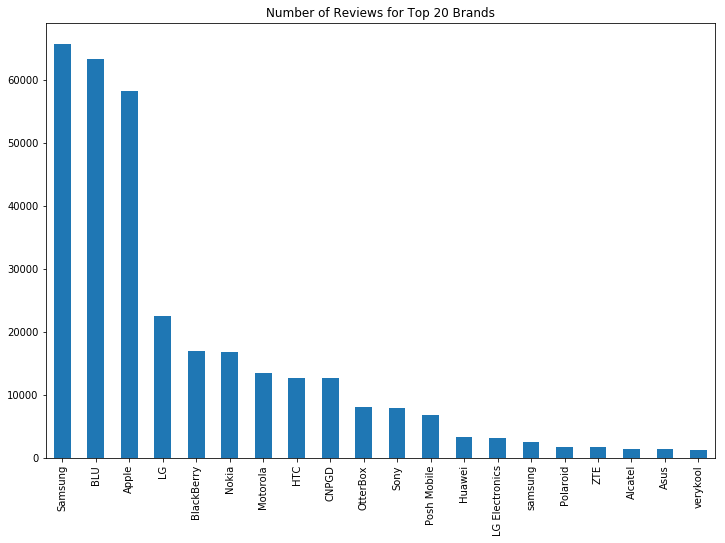

In [16]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

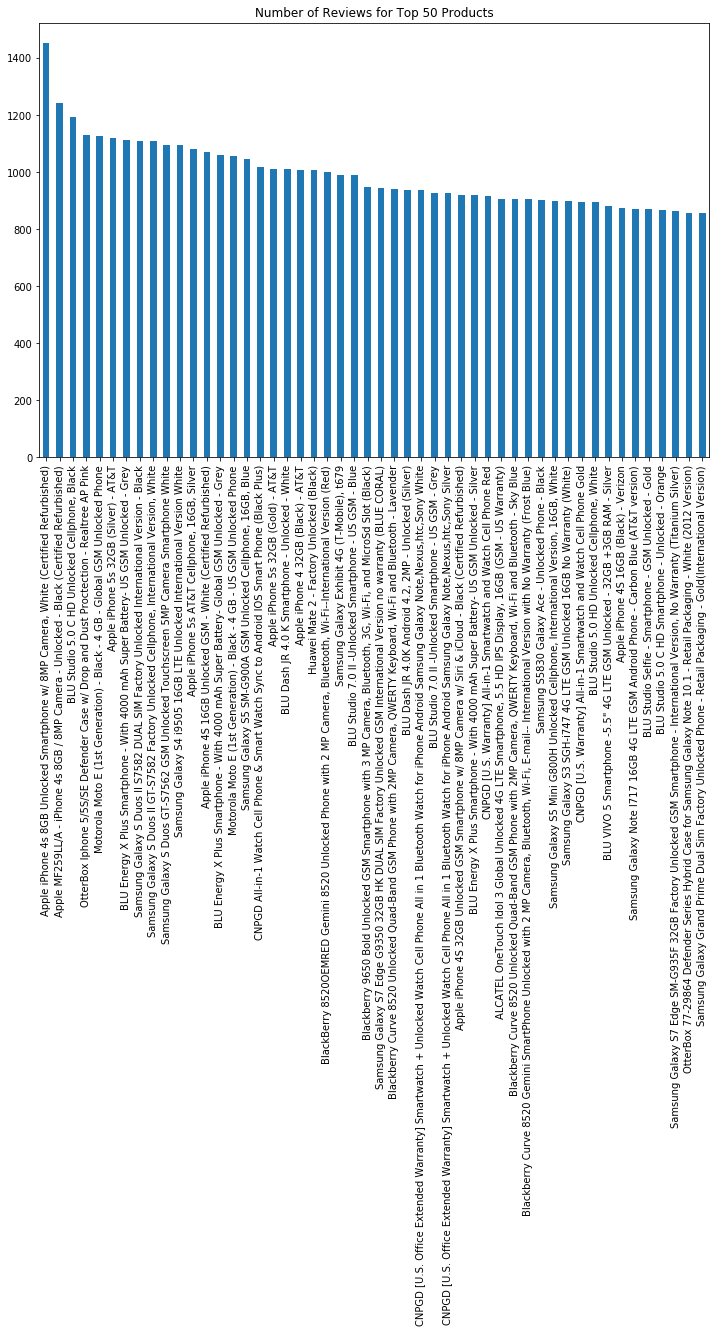

In [17]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

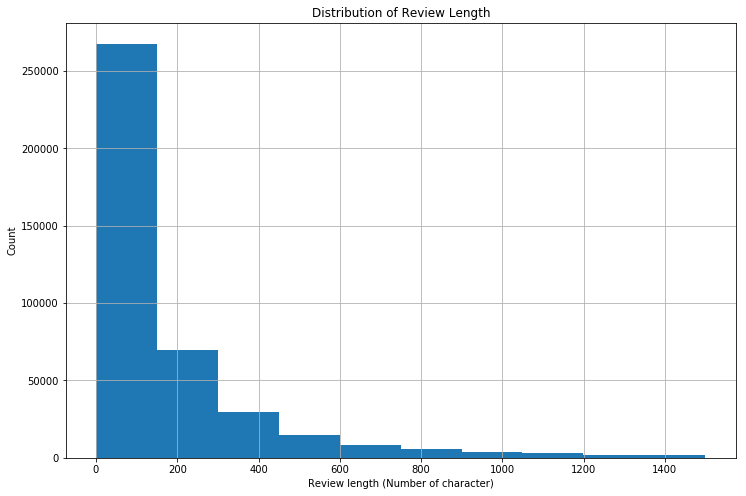

In [18]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

Untuk tujuan ilustrasi, kami hanya menggunakan 10% dari data dalam proyek ini. Sederhananya, kami hanya mempertimbangkan ulasan dengan sentimen positif (peringkat = 4, 5) dan sentimen negatif (peringkat = 1, 2), dan membuat ulasan dengan sentimen netral (peringkat 3).

### Prepare Data

In [19]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


### Train Test Split 

In [21]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 good product and fast shipping. thank you.


---
<a id="part3"></a>
## Part 3. Bag of Words

Tujuan dari proyek ini adalah untuk mengklasifikasikan ulasan menjadi sentimen positif dan negatif. Ada dua langkah utama yang terlibat. Pertama, kita perlu mencari kata yang disematkan untuk mengubah teks menjadi representasi numerik. Kedua, kami menyesuaikan representasi numerik dari teks ke algoritma pembelajaran mesin atau arsitektur pembelajaran yang mendalam.

Salah satu pendekatan yang umum dari embedding kata adalah embedding berbasis frekuensi seperti model Bag of Words (BoW). Model BoW mempelajari daftar vocubulary dari corpus yang diberikan dan mewakili setiap dokumen berdasarkan beberapa metode penghitungan kata. Pada bagian ini, kita akan mengeksplorasi kinerja model menggunakan BoW dengan algoritma pembelajaran terawasi. Inilah alur kerja di bagian ini.

* Langkah 1: Memproses ulasan mentah hingga ulasan yang dibersihkan
* Langkah 2: Buat BoW menggunakan CountVectorizer / Tfidfvectorizer di sklearn
* Langkah 3: Ubah teks ulasan menjadi representasi numerik (vektor fitur)

### Text Preprocessing

Preprocessing teks berikut diimplementasikan untuk mengonversi review mentah menjadi clean review, sehingga akan lebih mudah bagi kami untuk melakukan ekstraksi fitur pada langkah berikutnya.
* hapus tag html menggunakan BeautifulSoup
* menghapus non-karakter seperti angka dan simbol
* dikonversi ke huruf kecil
* hapus kata-kata berhenti seperti "the" dan "dan" jika diperlukan
* Konversikan ke root kata dengan membendung jika diperlukan

In [22]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [23]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

C:\Users\Hp\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Hp\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Hp\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP 

Show a cleaned review in the training set : 
 good product and fast shipping thank you


C:\Users\Hp\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

setelah ulasan dibersihkan, langkah selanjutnya adalah mengubah ulasan menjadi representasi numerik untuk algoritma pembelajaran mesin.

Dalam pustaka sklearn, kita bisa menggunakan CountVectorizer yang mengimplementasikan tokenization dan penghitungan kemunculan dalam satu kelas. Outputnya adalah representasi matriks yang jarang dari sebuah dokumen.

In [24]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 19607 

Show some feature names : 
 ['aa', 'areable', 'boot', 'clean', 'crushing', 'distortions', 'excatly', 'frills', 'heart', 'inverter', 'lolit', 'movie', 'over', 'predictable', 'reconnecting', 'scaling', 'soldto', 'tapped', 'ubuntu', 'wedges']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [26]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9184

AUC score : 0.8790

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       778
           1       0.93      0.96      0.95      2311

   micro avg       0.92      0.92      0.92      3089
   macro avg       0.90      0.88      0.89      3089
weighted avg       0.92      0.92      0.92      3089


Confusion Matrix : 
 [[ 622  156]
 [  96 2215]]


### TfidfVectorizer with Logistic Regression

Beberapa kata mungkin sering muncul tetapi memiliki sedikit informasi yang bermakna tentang sentimen ulasan tertentu. Alih-alih menggunakan penghitungan angka kejadian, kita dapat menggunakan transformasi tf-idf untuk menurunkan dampak kata-kata yang sering muncul dalam korpus yang diberikan.

Dalam pustaka sklearn, kita dapat menggunakan TfidfVectorizer yang mengimplementasikan penghitungan tokenization dan tf-idf dalam satu kelas.

In [27]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 5987 

Show some feature names : 
 ['00', 'changing', 'fall', 'letting', 'primarily', 'stars']


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [34]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'return' 'disappointed' 'waste' 'horrible' 'worst' 'poor' 'slow'
 'stopped' 'doesn']

Top 10 features with largest coefficients : 
['great' 'love' 'excellent' 'perfect' 'good' 'easy' 'best' 'far' 'amazing'
 'awesome']


In [35]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9310

AUC score : 0.8985

Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       778
           1       0.94      0.96      0.95      2311

   micro avg       0.93      0.93      0.93      3089
   macro avg       0.92      0.90      0.91      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 648  130]
 [  83 2228]]


---
<a id="par4"></a>
## Part 4. Word Cloud

Pada bagian ini, kami membuat kata cloud untuk ulasan sentimen positif dan ulasan sentimen negatif dari merek yang dipilih, untuk mendapatkan intuisi kata-kata yang sering muncul dalam berbagai sentimen.

In [42]:
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

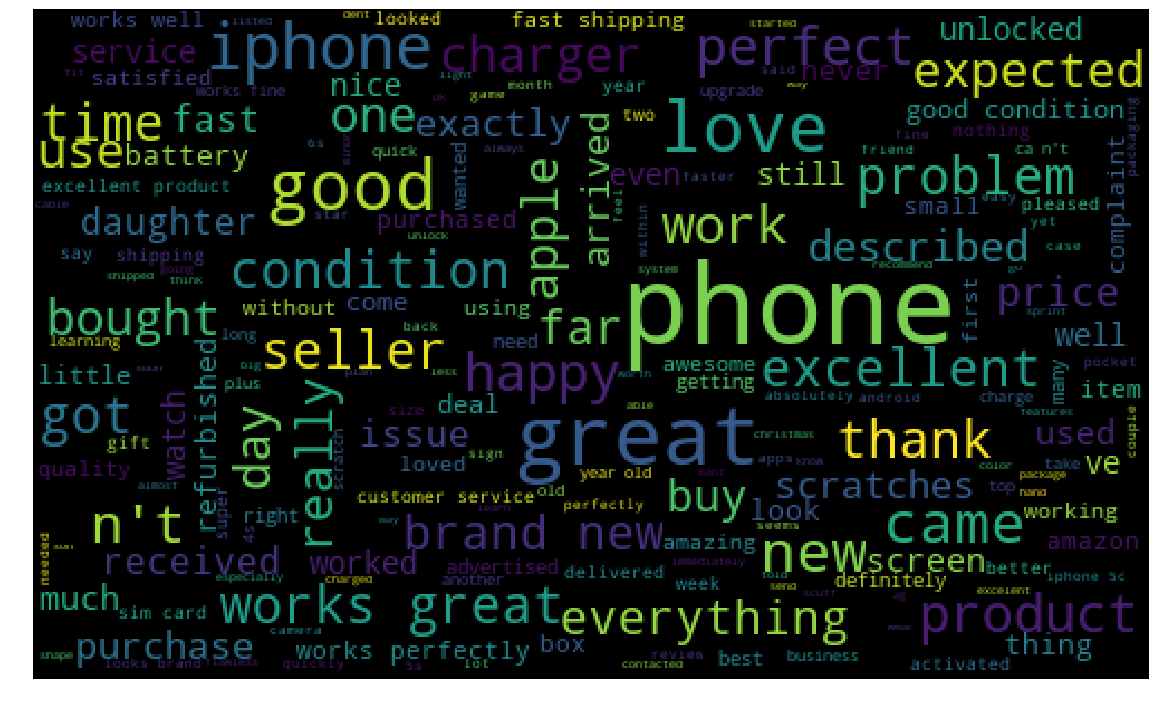

In [43]:
create_word_cloud(brand='Apple', sentiment=1)

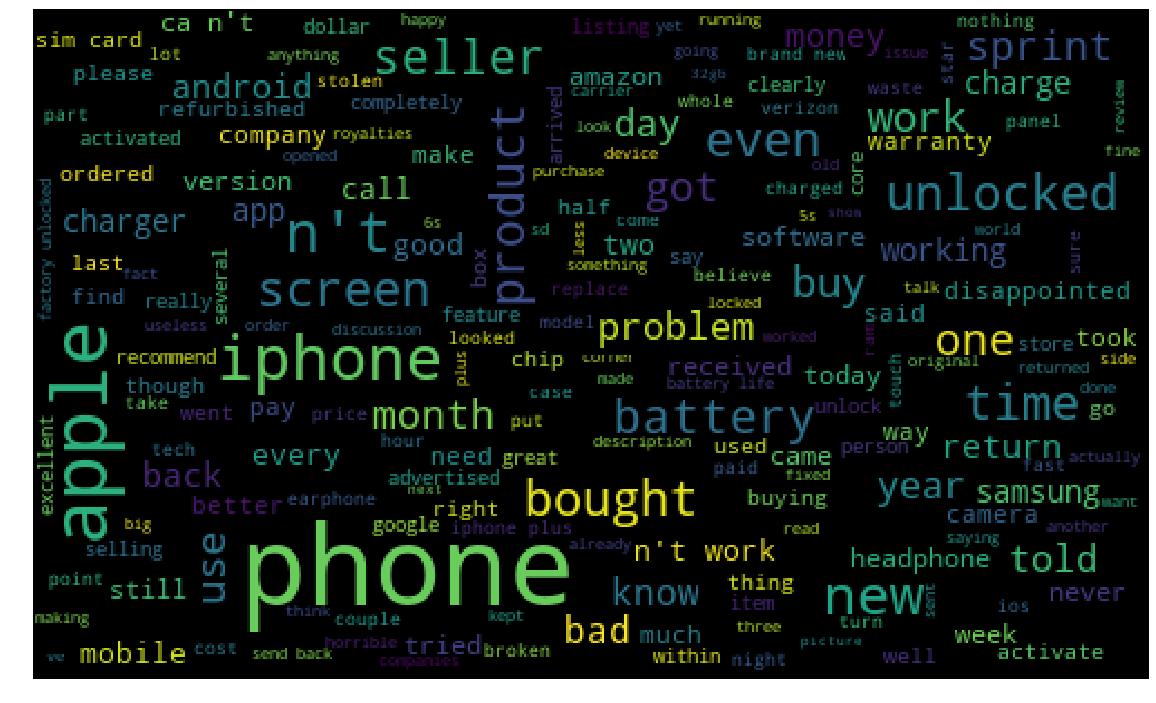

In [44]:
create_word_cloud(brand='Apple', sentiment=0)

In [57]:
a = pd.DataFrame(X_test)

In [58]:
a

,Reviews
230499,I love Nexus phones. My 2012 Nexus 4 still run...
331895,the best phone i ever knowCamera is not really...
287192,Came in the box and before it was promised!
280029,"I love this, before I used to be really nervou..."
53491,The only compliant is that the battery does no...
179502,"I found this product to be interesting, and af..."
358460,Very good battery life
218082,Amazing phone very fast and it is unlocked
25168,Great quality product.
311202,Very satisfied


In [46]:
X_test

230499    I love Nexus phones. My 2012 Nexus 4 still run...
331895    the best phone i ever knowCamera is not really...
287192          Came in the box and before it was promised!
280029    I love this, before I used to be really nervou...
53491     The only compliant is that the battery does no...
179502    I found this product to be interesting, and af...
358460                               Very good battery life
218082           Amazing phone very fast and it is unlocked
25168                                Great quality product.
311202                                       Very satisfied
230084    I've been very happy with the Nexus 5x. Defini...
158481                    DOESN'T WORK ON CRICKET YOU LIARS
156916    This is a wonderful masterpiece of 21st centur...
92857     me llego el producto BlackBerry 8520 Unlocked ...
403948    I just want to return the phone because it did...
220557    Had a g2 which I managed to break and upgraded...
351904           Brand new in box, as de

In [65]:
a = pd.DataFrame(predictions)

In [68]:
X_test = pd.DataFrame(X_test)

In [78]:
X_test['predictions'] = a[0]

In [80]:
a

,0
0,1
1,1
2,1
3,1
4,0
5,1
6,1
7,1
8,1
9,1


In [84]:
a[0].value_counts()

1    2357
0     732
Name: 0, dtype: int64

In [ ]:
plt.hist(a)